# Welcome to the -- Tutorial!

This Notebook calculate the scattering & intrinsic absorption parameters of the Rayleigh waves following the instruction proposed by Hirose et al. (2019).

## **Publication about this script**:
Hirose, T., Nakahara, H., & Nishimura, T. (2019). A passive estimation method of scattering and intrinsic absorption parameters from envelopes of seismic ambient noise cross‐correlation functions. Geophysical Research Letters, 46(7), 3634-3642. https://doi.org/10.1029/2018GL080553




Step: <br>
0) Filtering <br> 1) Calculation of mean-squared (MS) envelopes <br> 2) Selection of MS envelopes by SNR (e.g. inter-station distances <10 km and SNR>3) <br>
3) Selection of observed energy densities <br>
4) Calculation of synthesized energy densities via a grid search <br>
--- The search range of l (b) was between 0.4 and 10 km (0.00–0.40 s−1) with an increment of 0.1 km (0.02 s−1) <br>
5) Determination of best-fit parameters <br>

In [1]:
import os
import sys
import glob
import obspy
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyasdf
import scipy
import math

from obspy.signal.filter import bandpass

In [2]:
path = "./" 
data_path = os.path.join(path, "STACK_CC_BH_2020")

sfiles = sorted(glob.glob(os.path.join(data_path, '*PANH*/*.h5')))
print(sfiles)


['./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PANH.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5', './STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5']


## Read in HDF5 files

In [3]:
def read_pyasdf(sfile,ccomp):
    # useful parameters from each asdf file
    with pyasdf.ASDFDataSet(sfile, mode="r") as ds:
        alist = ds.auxiliary_data.list()
        try:
            dt = ds.auxiliary_data[alist[0]][ccomp].parameters["dt"]
            dist = ds.auxiliary_data[alist[0]][ccomp].parameters["dist"]
            print("working on %s (comp: %s) that is %5.2fkm apart. dt: %.3f " % (sfile, ccomp, dist, dt))
            #if dist == 0: 
            #    print("skip autocorrelation. ")
            #    return dist
            #    #continue
            # read stacked data 
            sdata = ds.auxiliary_data[alist[0]][ccomp].data[:]
            para = ds.auxiliary_data[alist[0]][ccomp].parameters

            # time domain variables
            nwin = len(alist[1:])
            npts = sdata.size
            tvec = np.arange(-npts // 2 + 1, npts // 2 + 1) * dt
            indx = np.where(np.abs(tvec) <= lag)[0]
            return dist,tvec,sdata
        
        except Exception:
            print("continue! no %s component exist" % ccomp)
            return None
            

In [4]:
comp_arr = ["ZZ", "ZR","ZT","RZ","TZ"]              # component 
#comp_arr = ["ZZ"] 
num_cmp=len(comp_arr)

fnum=len(sfiles)
print(fnum)

lag=100
samp=10
leng=int(lag*samp*2+1)
npts=leng
dt=1/samp


8


In [5]:
def plot_waveforms(ncmp,wav,fname,comp_arr):
    fig, ax = plt.subplots(1,ncmp, figsize=(16,3), sharex=False)
    
    for n in range(ncmp):
        absy=max(wav[n][1], key=abs)
        ax[n].set_ylim(absy*-1,absy)
        ax[n].plot(wav[n][0],wav[n][1])
        ax[n].set_xlabel("time [s]")
        ax[n].set_title(fname+" "+comp_arr[n])
    fig.tight_layout()
    plt.show()

(8, 5, 2, 2001)
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: ZZ) that is 30.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: ZZ) that is 30.64km apart. dt: 0.100 
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: ZR) that is 30.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: ZR) that is 30.64km apart. dt: 0.100 
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: ZT) that is 30.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: ZT) that is 30.64km apart. dt: 0.100 
0 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: RZ) that is 30.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR01.h5 (comp: RZ

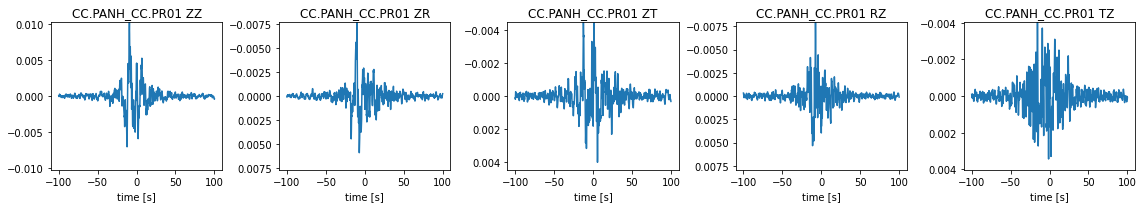

1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: ZZ) that is 31.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: ZZ) that is 31.64km apart. dt: 0.100 
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: ZR) that is 31.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: ZR) that is 31.64km apart. dt: 0.100 
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: ZT) that is 31.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: ZT) that is 31.64km apart. dt: 0.100 
1 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: RZ) that is 31.64km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR02.h5 (comp: RZ) that is 31.64k

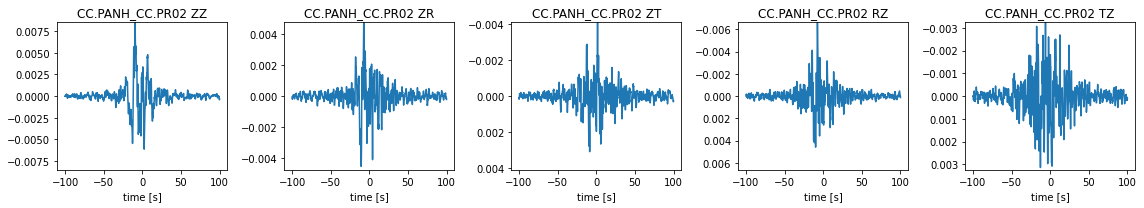

2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: ZZ) that is 30.14km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: ZZ) that is 30.14km apart. dt: 0.100 
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: ZR) that is 30.14km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: ZR) that is 30.14km apart. dt: 0.100 
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: ZT) that is 30.14km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: ZT) that is 30.14km apart. dt: 0.100 
2 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: RZ) that is 30.14km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR03.h5 (comp: RZ) that is 30.14k

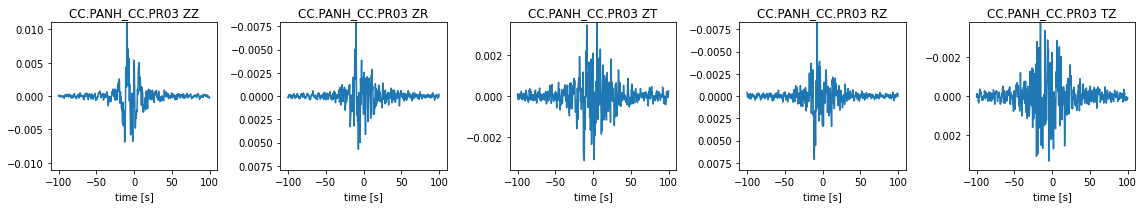

3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: ZZ) that is 27.51km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: ZZ) that is 27.51km apart. dt: 0.100 
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: ZR) that is 27.51km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: ZR) that is 27.51km apart. dt: 0.100 
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: ZT) that is 27.51km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: ZT) that is 27.51km apart. dt: 0.100 
3 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: RZ) that is 27.51km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR04.h5 (comp: RZ) that is 27.51k

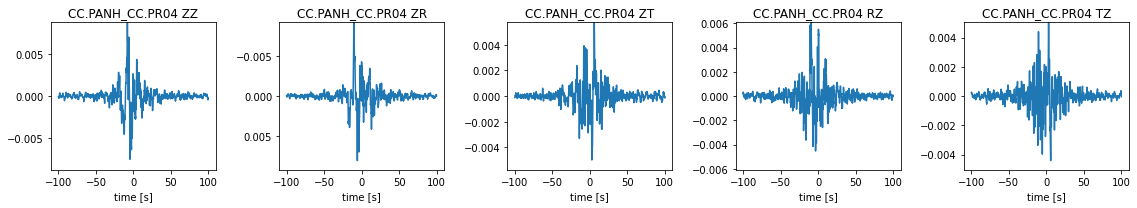

4 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: ZZ) that is 23.44km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: ZZ) that is 23.44km apart. dt: 0.100 
4 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: ZR) that is 23.44km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: ZR) that is 23.44km apart. dt: 0.100 
4 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: ZT) that is 23.44km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: ZT) that is 23.44km apart. dt: 0.100 
4 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: RZ) that is 23.44km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.PR05.h5 (comp: RZ) that is 23.44k

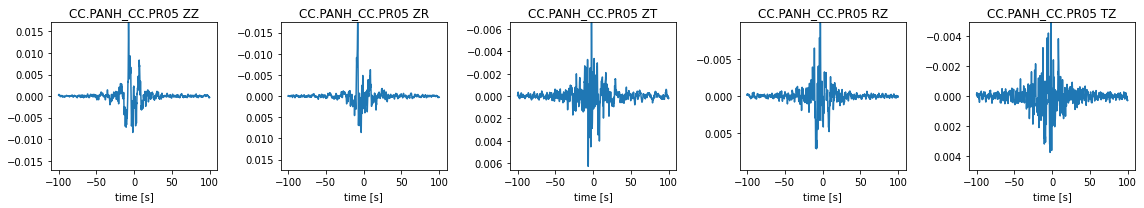

5 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: ZZ) that is 23.52km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: ZZ) that is 23.52km apart. dt: 0.100 
5 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: ZR) that is 23.52km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: ZR) that is 23.52km apart. dt: 0.100 
5 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: ZT) that is 23.52km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: ZT) that is 23.52km apart. dt: 0.100 
5 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: RZ) that is 23.52km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.RUSH.h5 (comp: RZ) that is 23.52k

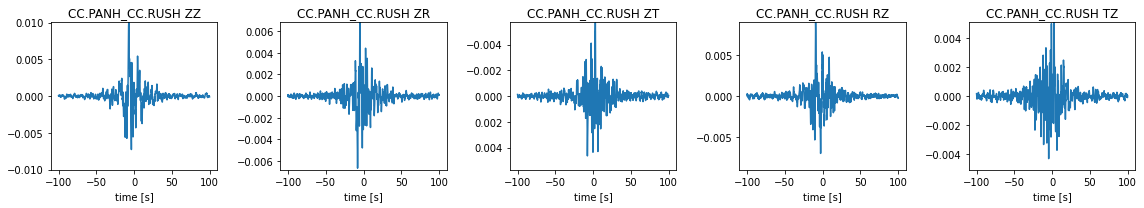

6 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 ZZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: ZZ) that is 23.70km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: ZZ) that is 23.70km apart. dt: 0.100 
6 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 ZR
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: ZR) that is 23.70km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: ZR) that is 23.70km apart. dt: 0.100 
6 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 ZT
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: ZT) that is 23.70km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: ZT) that is 23.70km apart. dt: 0.100 
6 ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 RZ
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: RZ) that is 23.70km apart. dt: 0.100 
working on ./STACK_CC_BH_2020/CC.PANH/CC.PANH_CC.SIFT.h5 (comp: RZ) that is 23.70k

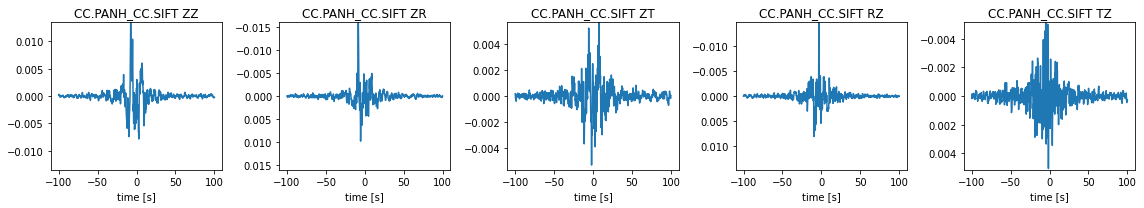

In [6]:
stackf=np.ndarray((fnum,num_cmp,2,leng))  
print(stackf.shape)
vdist=np.zeros((fnum,1))  # S-R distance array
fname=[]                  # file name array


aa=0
# loop through each station-pair
for sfile in sfiles:
    ncmp=0
    
    # skip auto-correlation
    if ( sfile.split("/")[3].split("_")[0] == sfile.split("/")[3].split("_")[1].split(".h5")[0] ):  
        continue
    fname.append(sfile.split("/")[3].split(".h5")[0])
    for ccomp in comp_arr:        
        print(aa, sfile, ccomp)
        # read stacked waveforms
        if ( read_pyasdf(sfile,ccomp) == None):
            continue
        dist, tvec,sdata = read_pyasdf(sfile,ccomp) # read waveform from pyasdf 
        stackf[aa][ncmp]=[tvec,sdata]
        vdist[aa]=dist
        ncmp=ncmp+1
    plot_waveforms(num_cmp,stackf[aa],fname[aa],comp_arr)
    
    aa=aa+1
fnum=len(fname)


### Step 0 --- Filtering

In [7]:
def plot_filtered_waveforms(freq,tt,wav,fname):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,3), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=max(wav[fb], key=abs)
        #absx=max(tt, key=abs)
        #ax[fb].set_xlim(absx*-1,absx)
        ax[fb].set_ylim(absy*-1,absy)
        ax[fb].plot(tt,wav[fb], "k-", linewidth=0.2)
        #ax[fb].plot(wav_fold[0],wav_fold[fb+1], "b-", linewidth=1)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude")
        ax[fb].set_title( "%s   %s   @%4.2f-%4.2f Hz" % ( fname,ccomp,fmin,fmax ) )
    
    fig.tight_layout()
    plt.show()

### Step 1 --- Calculation of mean-squared (MS) envelopes --> ***Eobs***  <br>
**need to add coda normalization** <br>
*/"The summed MS envelope was then normalized using their values at lapse times greater than twice the arrival times of direct Rayleigh waves for farthest station pairs (coda normalization)"*

--> normalized MS envelope is referred to as the observed energy density Eobs 

CC.PANH_CC.PR01 ZZ


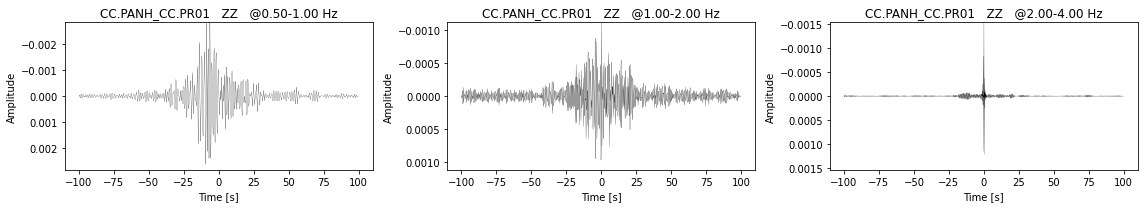

CC.PANH_CC.PR01 ZR


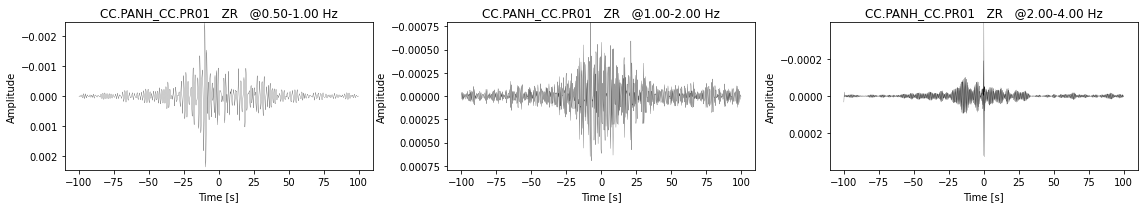

CC.PANH_CC.PR01 ZT


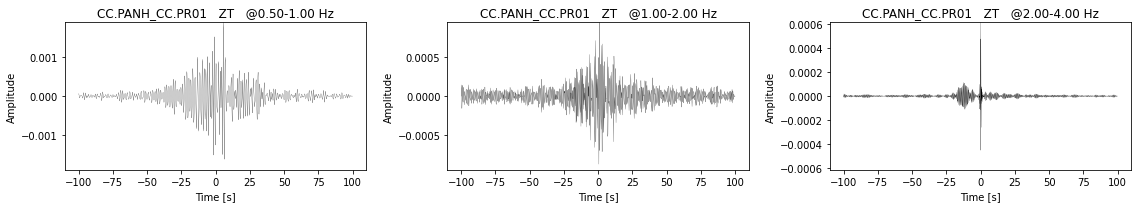

CC.PANH_CC.PR01 RZ


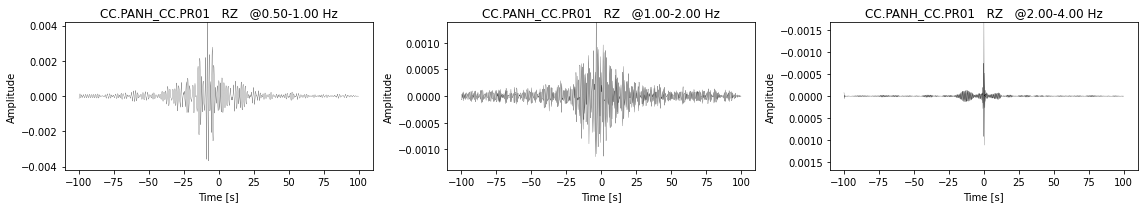

CC.PANH_CC.PR01 TZ


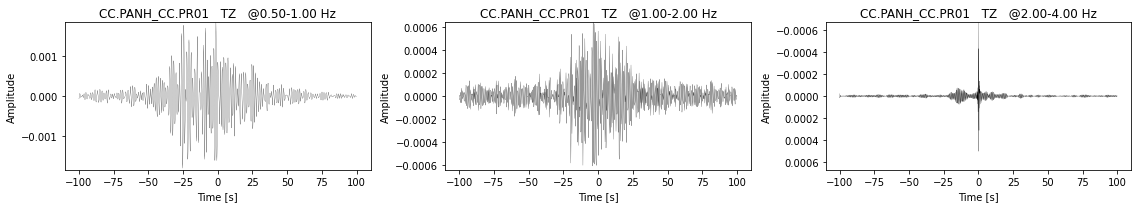

CC.PANH_CC.PR02 ZZ


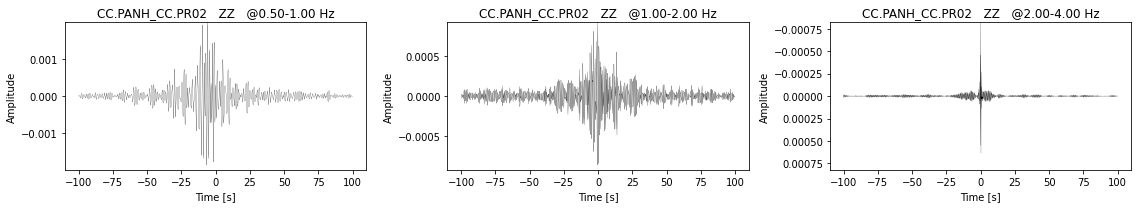

CC.PANH_CC.PR02 ZR


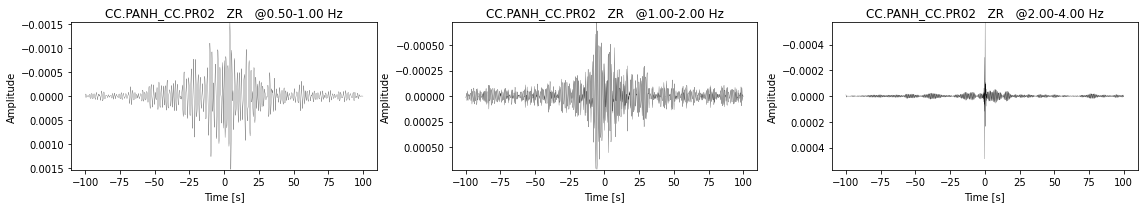

CC.PANH_CC.PR02 ZT


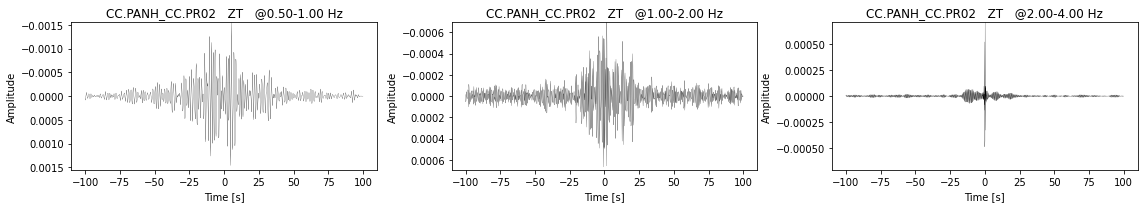

CC.PANH_CC.PR02 RZ


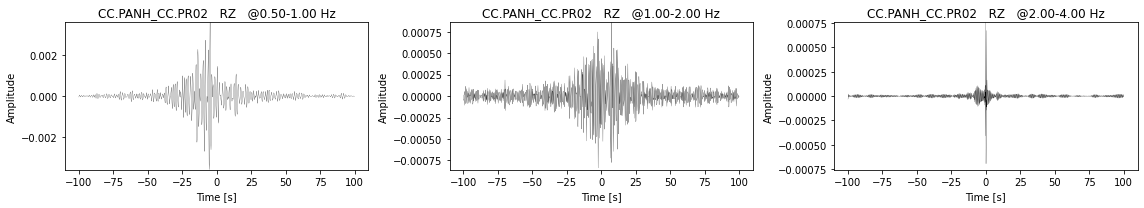

CC.PANH_CC.PR02 TZ


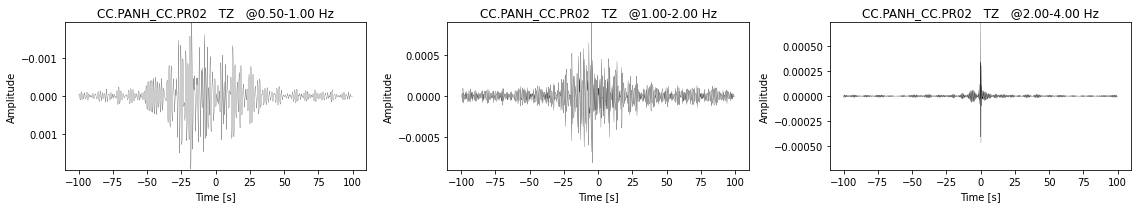

CC.PANH_CC.PR03 ZZ


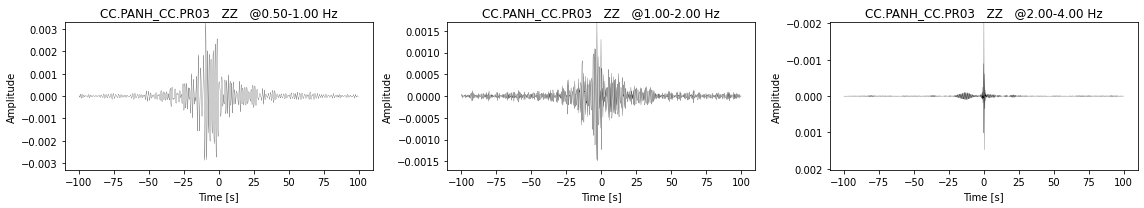

CC.PANH_CC.PR03 ZR


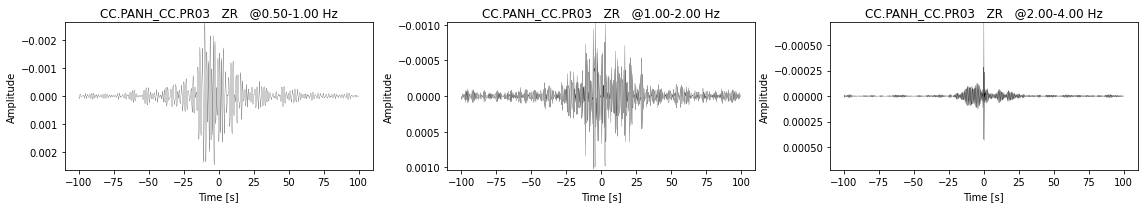

CC.PANH_CC.PR03 ZT


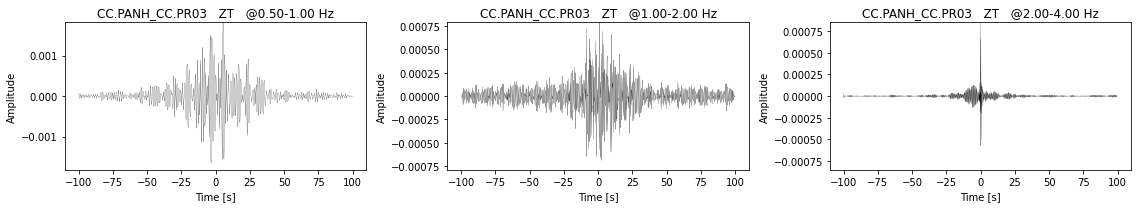

CC.PANH_CC.PR03 RZ


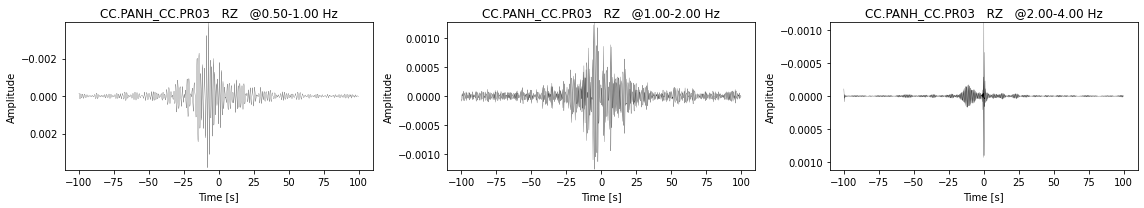

CC.PANH_CC.PR03 TZ


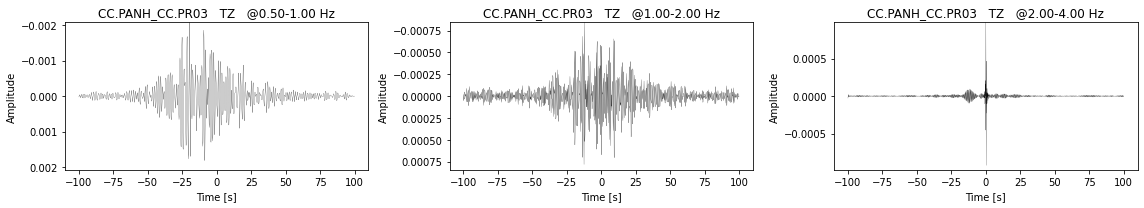

CC.PANH_CC.PR04 ZZ


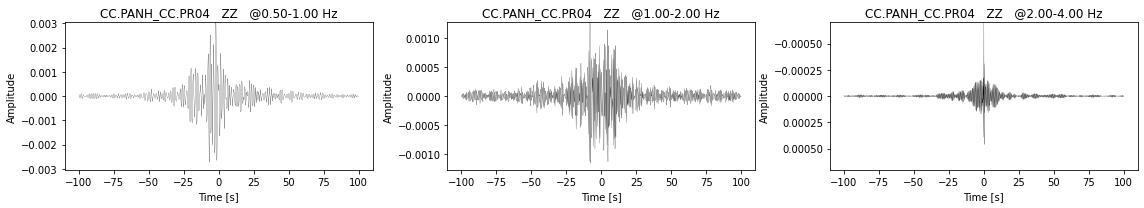

CC.PANH_CC.PR04 ZR


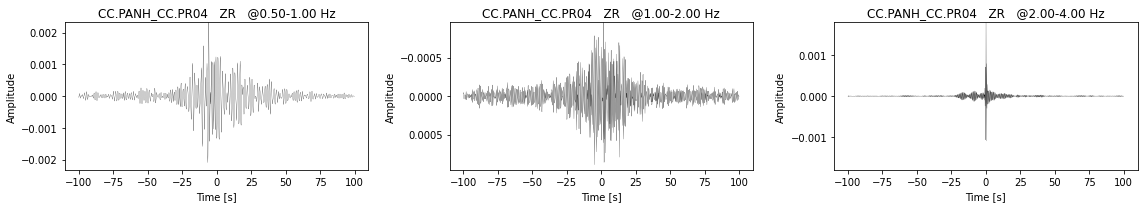

CC.PANH_CC.PR04 ZT


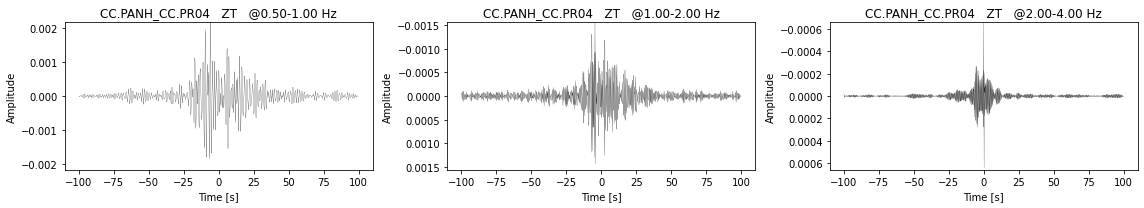

CC.PANH_CC.PR04 RZ


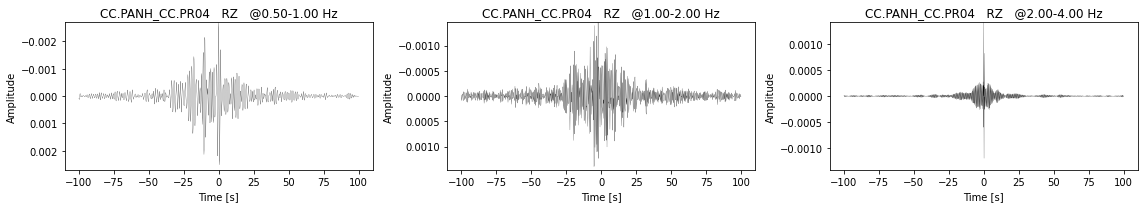

CC.PANH_CC.PR04 TZ


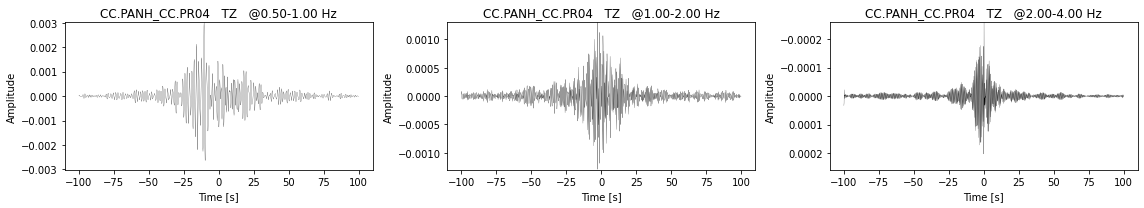

CC.PANH_CC.PR05 ZZ


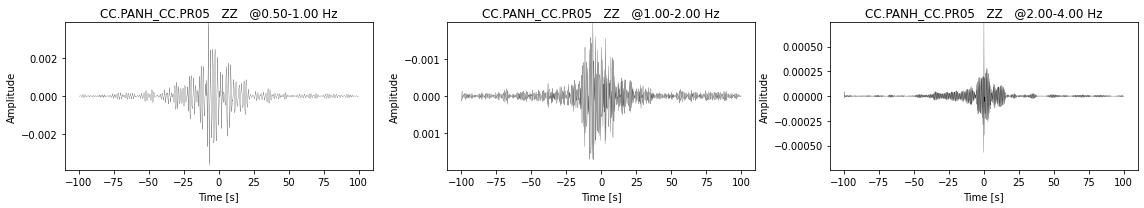

CC.PANH_CC.PR05 ZR


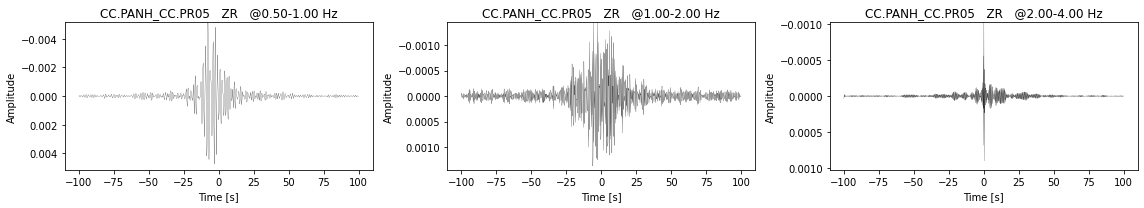

CC.PANH_CC.PR05 ZT


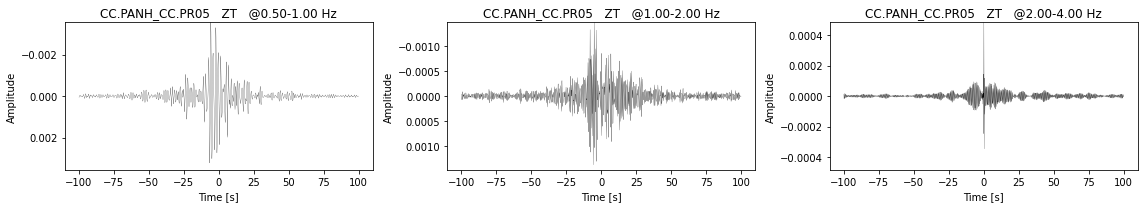

CC.PANH_CC.PR05 RZ


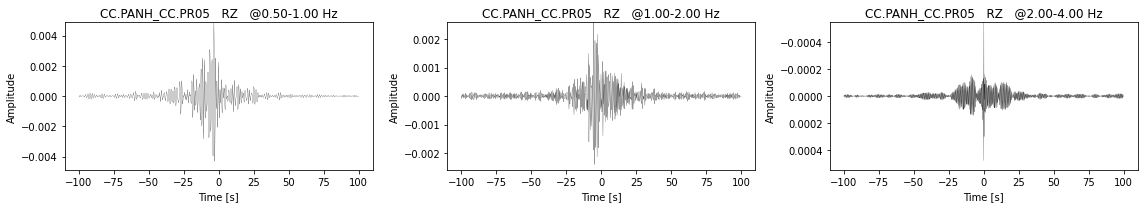

CC.PANH_CC.PR05 TZ


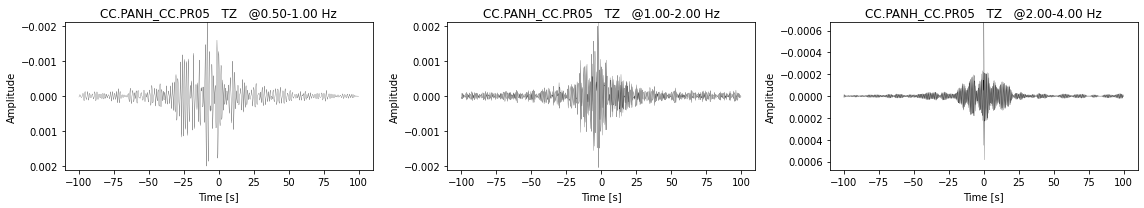

CC.PANH_CC.RUSH ZZ


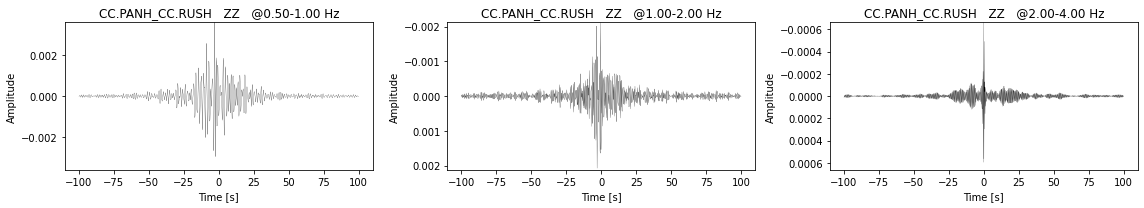

CC.PANH_CC.RUSH ZR


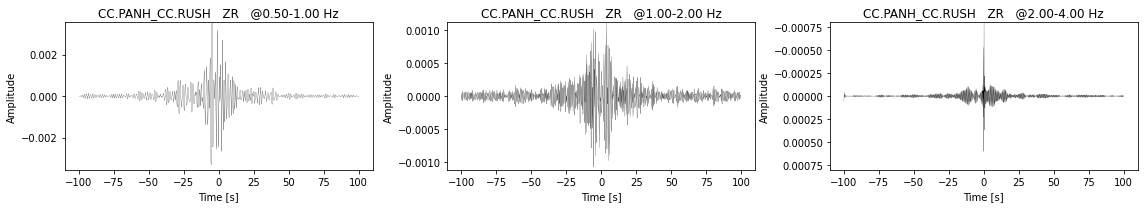

CC.PANH_CC.RUSH ZT


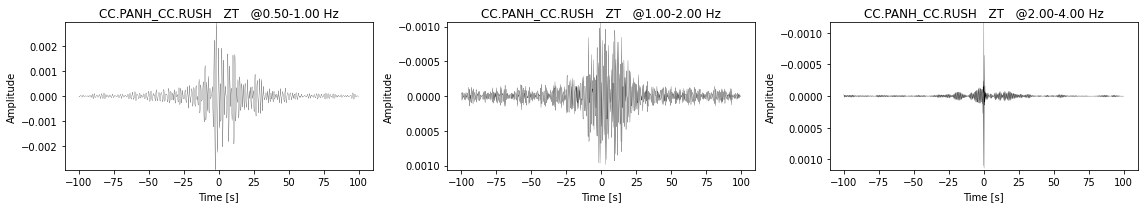

CC.PANH_CC.RUSH RZ


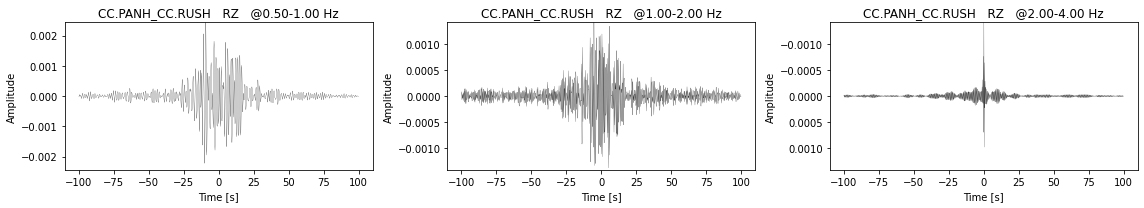

CC.PANH_CC.RUSH TZ


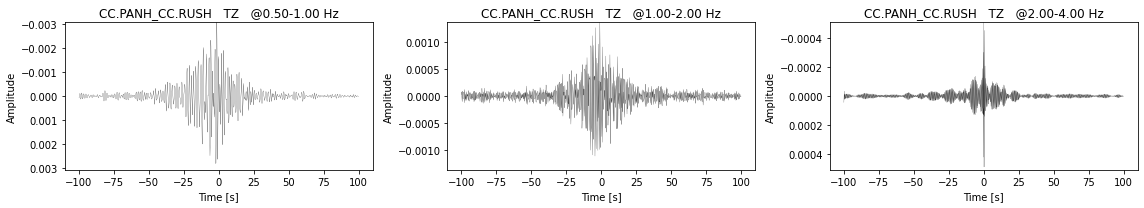

CC.PANH_CC.SIFT ZZ


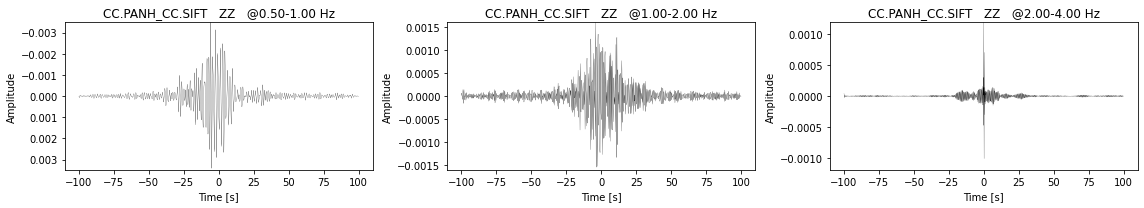

CC.PANH_CC.SIFT ZR


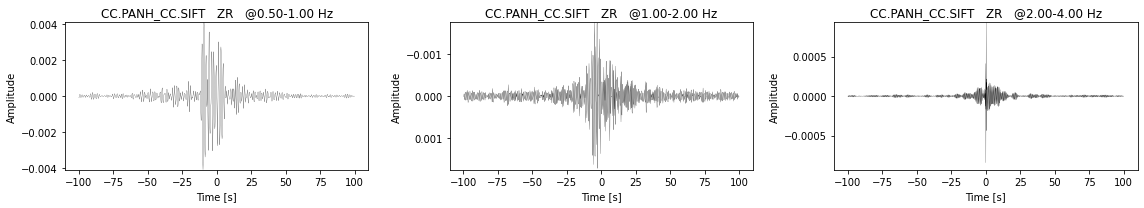

CC.PANH_CC.SIFT ZT


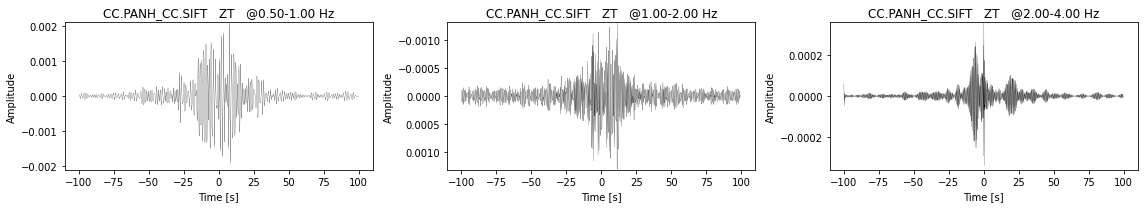

CC.PANH_CC.SIFT RZ


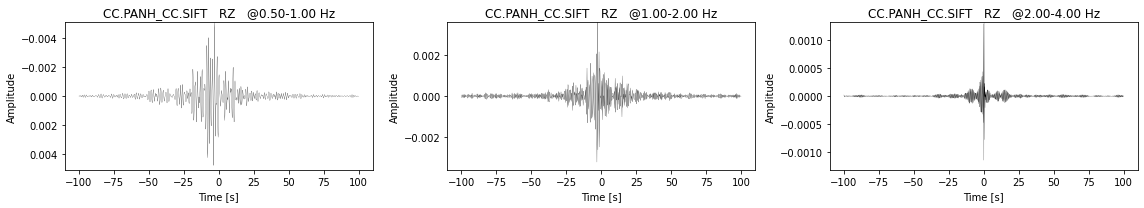

CC.PANH_CC.SIFT TZ


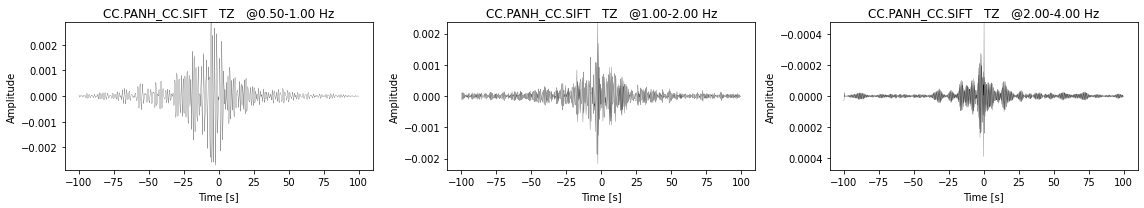

In [8]:
freq = [0.5, 1, 2,4]  # targeted frequency band for waveform monitoring
nfreq = len(freq) - 1

indx = npts // 2                      # half-side number of points
MSE=np.ndarray((fnum,num_cmp,nfreq+1,npts)) # filtered two-side averaged stack CF

for aa in range (fnum):
    dafbp=np.ndarray((nfreq,npts))
      
    for ncmp in range (len(comp_arr)):
        ccomp=comp_arr[ncmp]
        print(fname[aa],ccomp)
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]
            tt = np.arange(0, npts) * dt
            data = stackf[aa][ncmp][1]
            dafbp[fb] = bandpass(data, fmin, fmax, int(1 / dt), corners=4, zerophase=True)
        
        MSE[aa][ncmp]=[stackf[aa][ncmp][0],dafbp[0],dafbp[1],dafbp[2]] 
        plot_filtered_waveforms(freq,stackf[aa][ncmp][0],dafbp,fname[aa])



In [9]:
#Python3 program to calculate Mean Square
import math
#Function that Calculate Mean Square
def msValue(arr, n):
    square = 0
    mean = 0.0
    
    #Calculate square
    for i in range(0,n):
        square += (arr[i]**2)
     
    #Calculate Mean
    mean = square / (float)(n)
    
    return mean

In [10]:
def plot_envelope(comp_arr,freq,msv,msv_mean,fname,vdist):
    
    nfreq = len(freq) - 1
    ncmp = len(comp_arr)
    
    fig, ax = plt.subplots(ncmp+1,nfreq, figsize=(16,10), sharex=False)   
    for n in  range(len(comp_arr)):
        
        for fb in range(nfreq):
            fmin=freq[fb]
            fmax=freq[fb+1]    
            ax[n,fb].plot(msv[n][0][:], msv[n][fb+1], "k-", linewidth=0.5)
            ax[n,fb].set_title("%s   %.2fkm  %s   @%4.2f-%4.2f Hz" % (fname,vdist,comp_arr[n],fmin,fmax))
            ax[n,fb].set_xlabel("Time [s]")
            ax[n,fb].set_ylabel("Amplitude")
            
    for fb in range(nfreq):
        ax[-1,fb].plot(msv_mean[0], msv_mean[fb+1], "b-", linewidth=1)
        ax[-1,fb].set_title(" Mean Squared Value %.2fkm  @%4.2f-%4.2f Hz" % (vdist,fmin,fmax))
        ax[-1,fb].set_xlabel("Time [s]")
        ax[-1,fb].set_ylabel("Amplitude")            

    plt.tight_layout()   
    plt.show()            
            

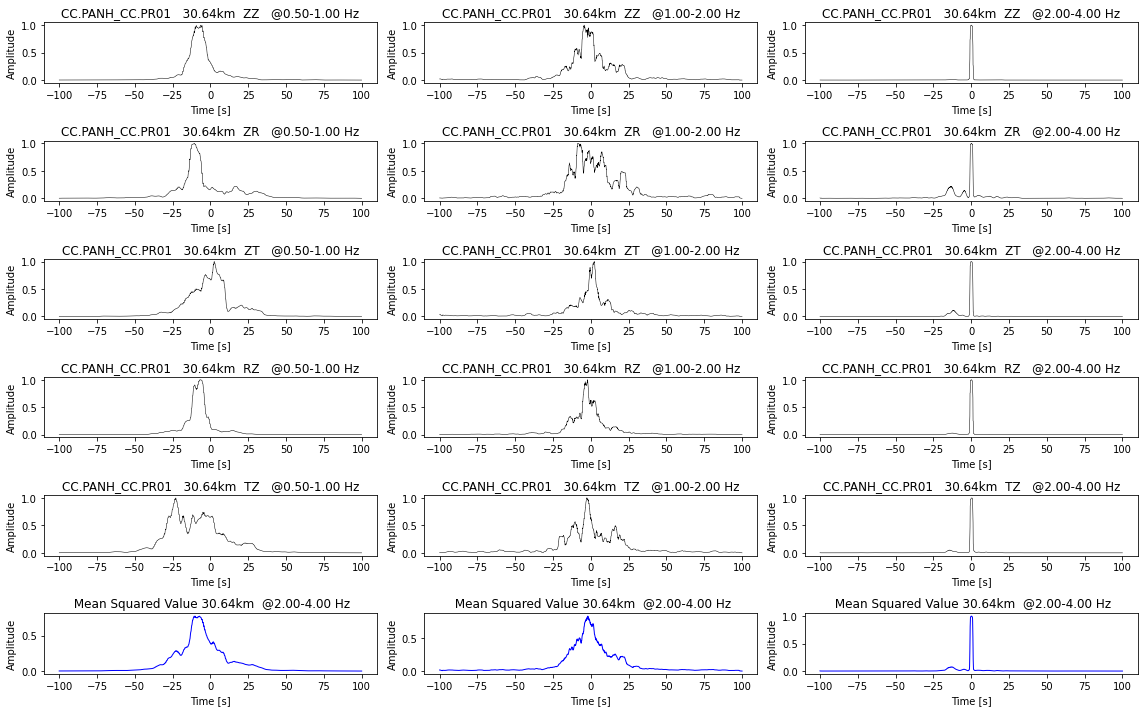

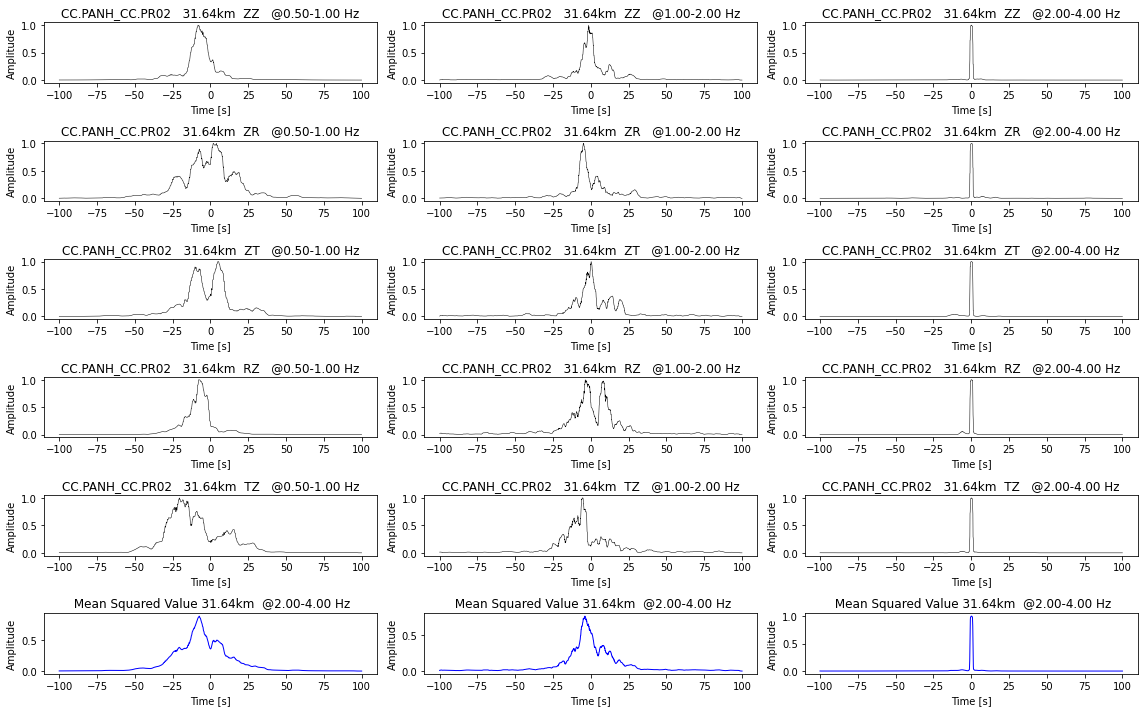

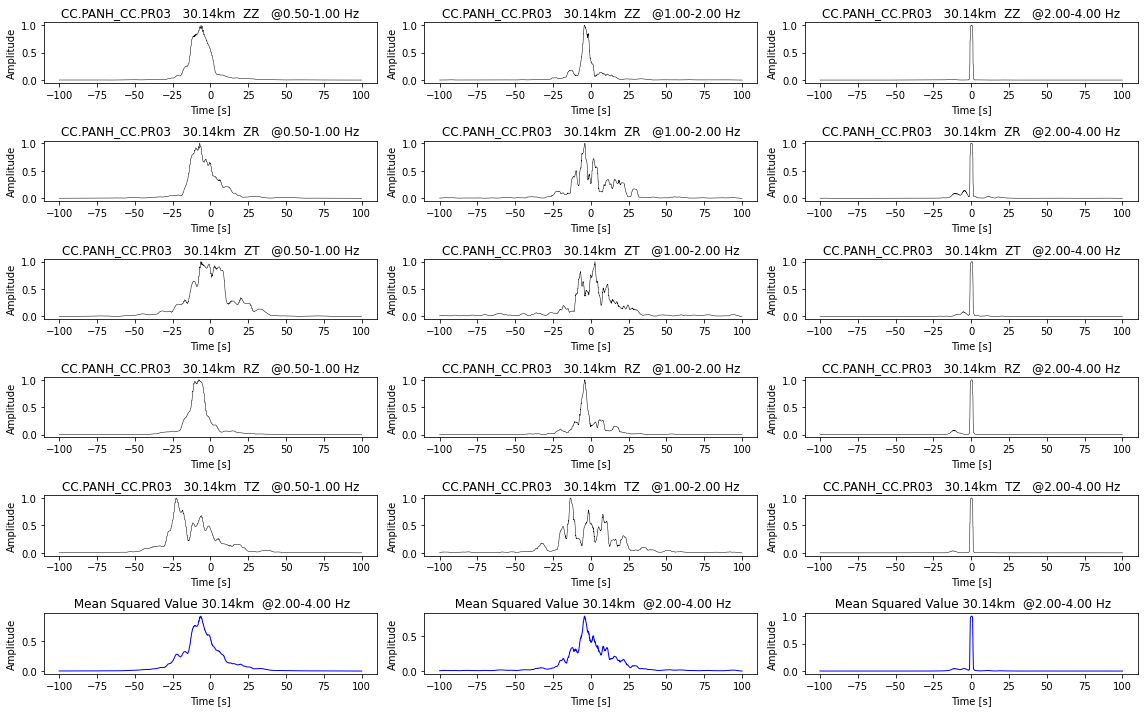

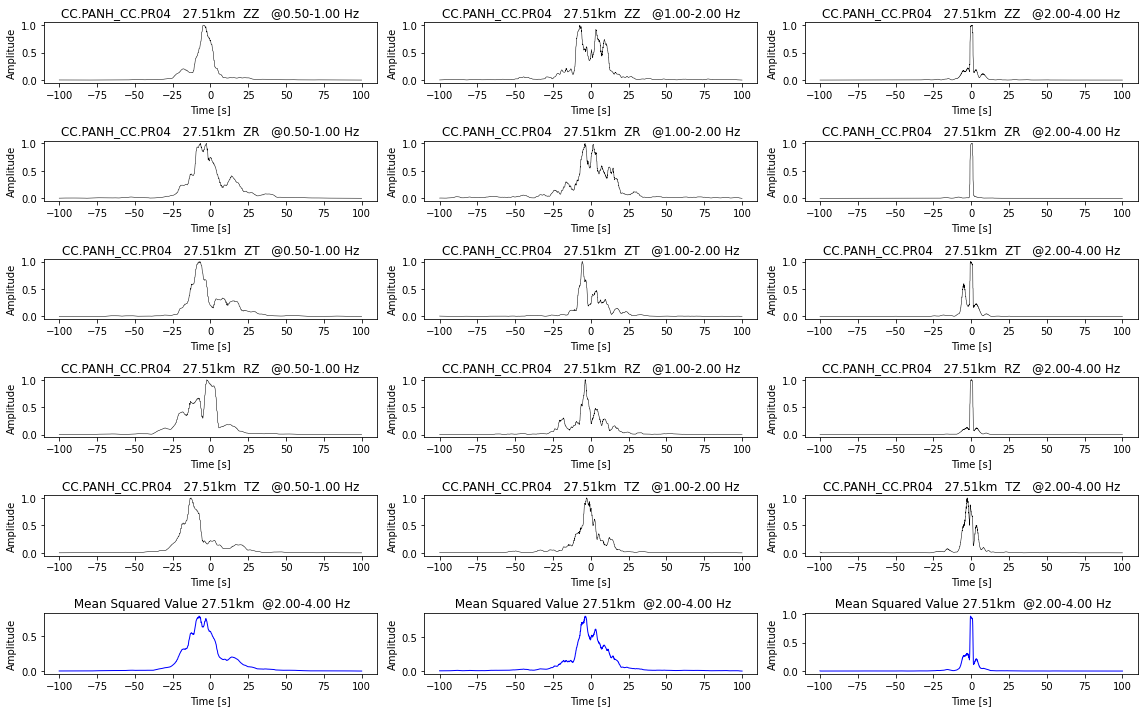

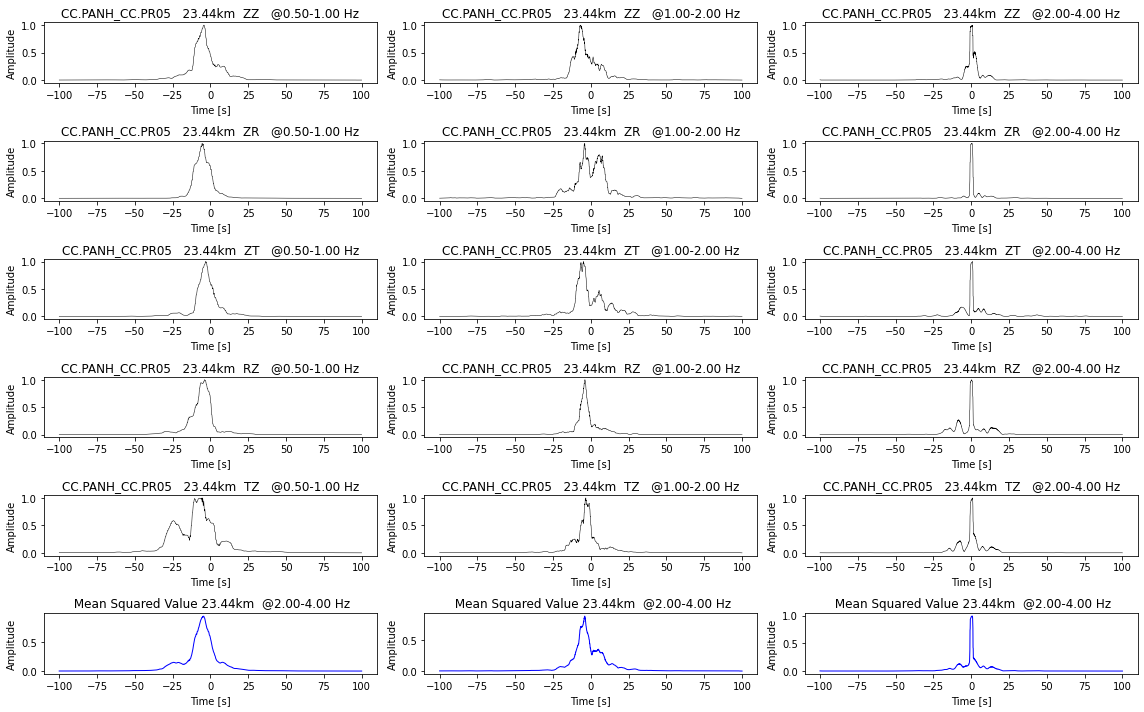

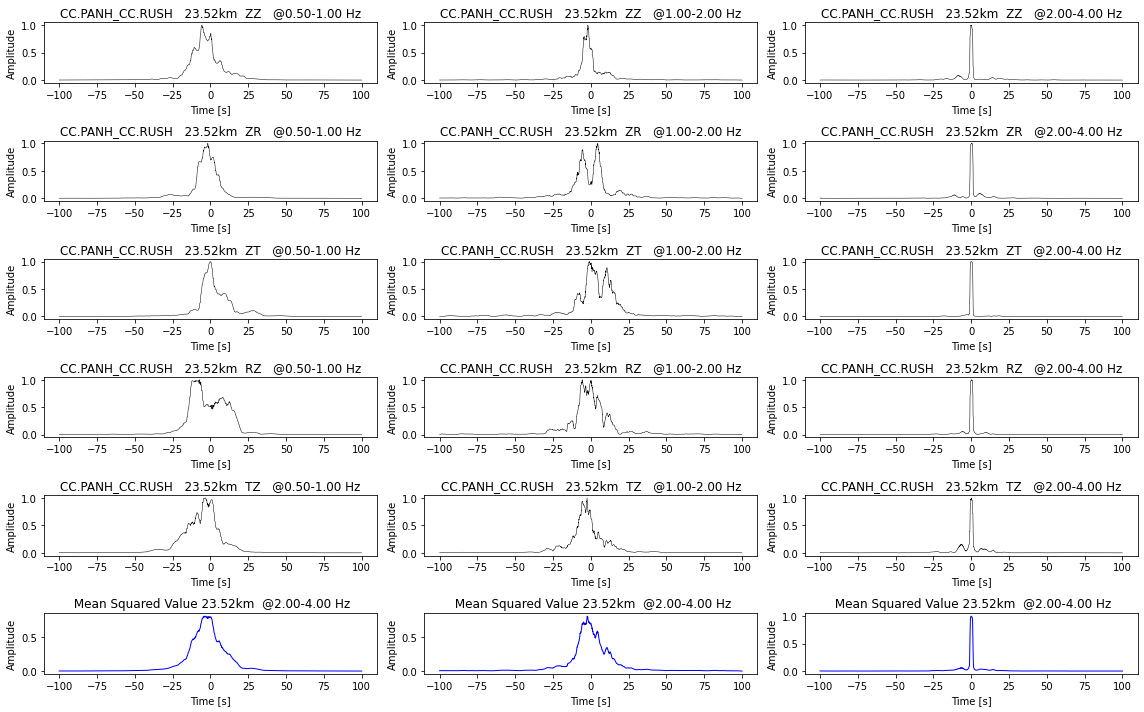

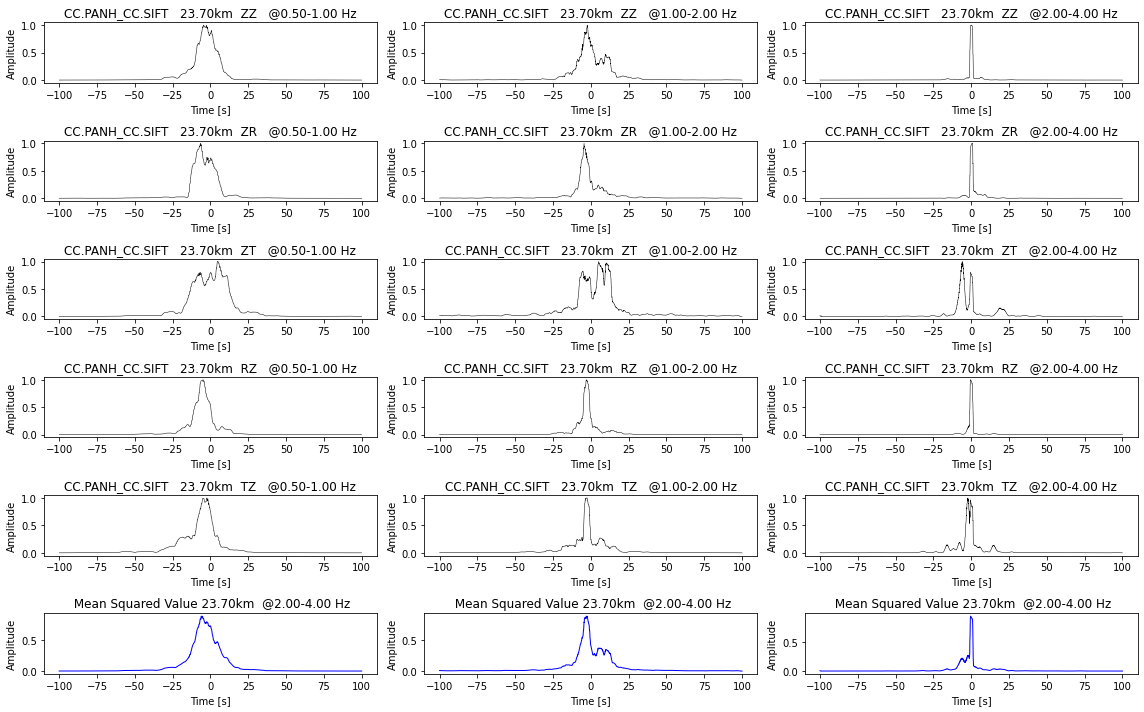

In [11]:
msv=np.ndarray((fnum,num_cmp,nfreq+1,npts))
msv_mean=np.ndarray((fnum,nfreq+1,npts))
msv[:][:][:][:]=0.
msv_mean[:][:][:]=0.
#print(msv.shape)

winlen=[8,4,2]   # smoothing window lengths corresponding to the frequency bands
for aa in range(fnum):

    for ncmp in  range(len(comp_arr)):
        ccomp=comp_arr[ncmp]
        msv[aa][ncmp][0]=MSE[aa][ncmp][0][:]
        for fb in range(nfreq):
            data=MSE[aa][ncmp][fb+1][:]
            fmin=freq[fb]
            fmax=freq[fb+1]
        
            # small window smoothing
            npt=int(winlen[fb]/dt)+1
            half_npt=int(npt/2)
            arr=np.zeros(int(npt))
            for jj in range(0, (npts)):
                if jj < half_npt:
                    arr=data[jj: jj+half_npt]
                elif jj > (npts)-half_npt:
                    arr=data[jj: npts]
                else:
                    arr=data[jj-half_npt : jj+half_npt]
                msv[aa][ncmp][fb+1][jj] = msValue(arr,len(arr))
        
            msv[aa][ncmp][fb+1]=msv[aa][ncmp][fb+1]/np.max(msv[aa][ncmp][fb+1])  # self-normalized 
    
    msv_mean[aa][0]=msv[aa][0][0][:]
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        for ncmp in range(len(comp_arr)):
            msv_mean[aa][fb+1]+=msv[aa][ncmp][fb+1][:]
        msv_mean[aa][fb+1]=msv_mean[aa][fb+1]/len(comp_arr)
        
    plot_envelope(comp_arr,freq,msv[aa],msv_mean[aa],fname[aa],vdist[aa])


In [12]:
def plot_fmsv_waveforms(freq,wav,fname):
    nfreq = len(freq) - 1
    fig, ax = plt.subplots(1,nfreq, figsize=(16,2), sharex=False)
    
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]
        absy=1 #max(wav[fb], key=abs)
        ax[fb].set_ylim(-0.1,absy)
        ax[fb].plot(wav[0],wav[fb+1], "k-", linewidth=0.5)
        ax[fb].set_xlabel("Time [s]")
        ax[fb].set_ylabel("Amplitude")
        ax[fb].set_title( "%s   @%4.2f-%4.2f Hz" % ( fname,fmin,fmax ) )
    
    fig.tight_layout()
    plt.show()

CC.PANH_CC.PR01


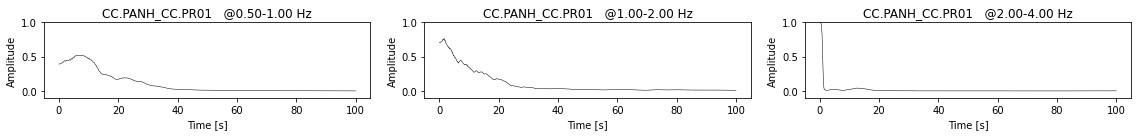

CC.PANH_CC.PR02


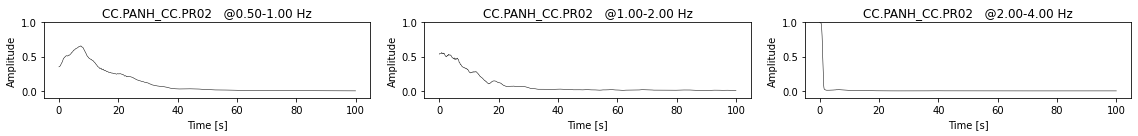

CC.PANH_CC.PR03


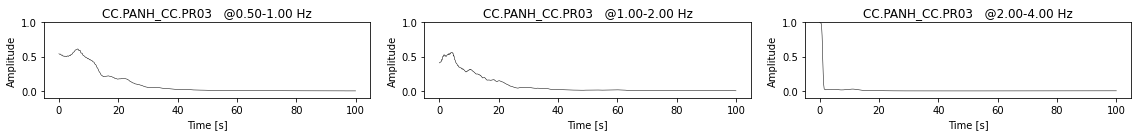

CC.PANH_CC.PR04


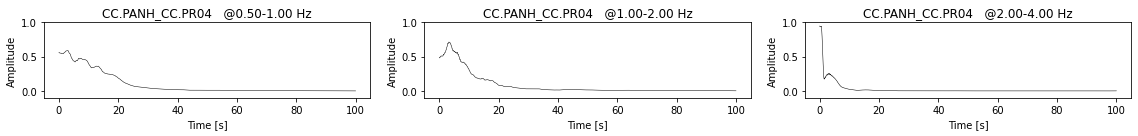

CC.PANH_CC.PR05


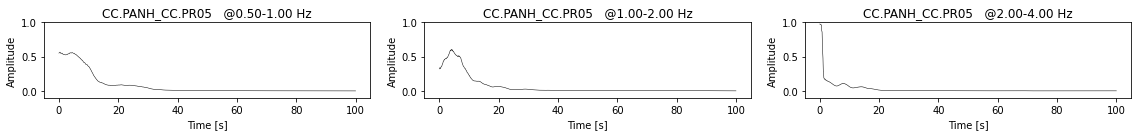

CC.PANH_CC.RUSH


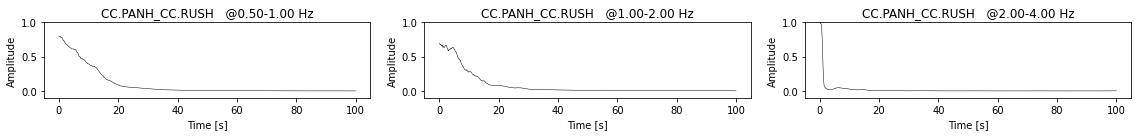

CC.PANH_CC.SIFT


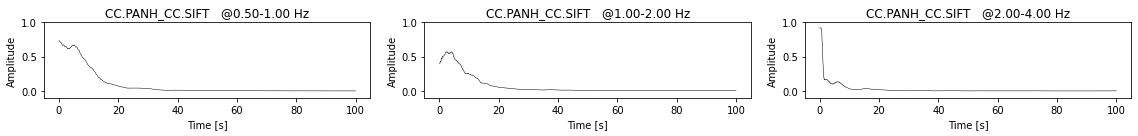

In [13]:
data_sym=np.ndarray((nfreq,indx+1)) # two-side averaged stack CF
fmsv_mean=np.ndarray((fnum,nfreq+1,indx+1))

for aa in range (fnum):
    for fb in range(nfreq):
        fmin=freq[fb]
        fmax=freq[fb+1]            # stack positive and negative lags  
        sym = 0.5 * msv_mean[aa][fb+1][indx:] + 0.5 * np.flip(msv_mean[aa][fb+1][: indx + 1], axis=0)
        data_sym[fb]=sym
        
    print(fname[aa])  
    fmsv_mean[aa]=[msv[aa][0][0][indx:],data_sym[0],data_sym[1],data_sym[2]]
    plot_fmsv_waveforms(freq,fmsv_mean[aa],fname[aa])



### Step 2 ---  Selection of MS envelopes by SNR 


### Step 3 --- Selection of observed energy densities 

### Step 4 --- Calculation of synthesized energy densities via a grid search 
### #The 2-D radiative transfer equation for scalar waves  ***(Shang and Gao 1988; Sato 1993)***
Assuming isotropic scattering and source radiation in infinite medium to calculate ***synthesized energy densities  Esyn*** :

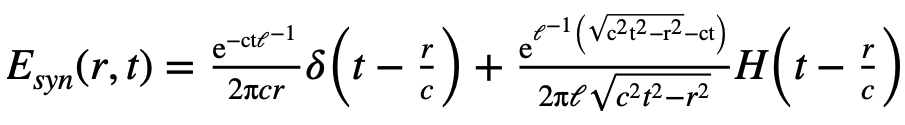

* l scattering mean free paths 
* c is the Rayleigh wave velocity
* r is the distance between the source and receiver
* H is the Heaviside function

* ### ***b is intrinsic absorption parameter***


In [14]:
# Dirac delta function
def impulse(x):
    return 1 * (x == 0)  

# Heaviside function (step function)
def step(x):
    return 1 * (x > 0)

# Esyn -->The 2-D radiative transfer equation for scalar waves 
def ESYN_RadiaTrans(mean_free,tm, r, c):
       
    s0=c**2 * tm**2 -r**2
    if s0 > 0:
        # first term
        a1up=math.exp(-1 * c * tm * (mean_free**(-1)))
        a1bot= 2 * math.pi * c * r
        #first= (a1up/a1bot)* scipy.signal.unit_impulse( tm-r/c ,'mid')
        first= (a1up/a1bot)* impulse( tm-r/c )
        
        # second term
        ind2=mean_free**(-1) * (math.sqrt(s0)-c*tm)
        a2up=math.exp(ind2)
        a2bot=2 * math.pi * mean_free * math.sqrt(s0)
        #second=(a2up)/(a2bot)* math.heaviside(tm-r/c)
        second=(a2up/a2bot)* step(tm-r/c)
        
        #print("A1: %.4f %.4f %.4f " % ((a1up/a1bot),a1up,a1bot),"  , A2: %.4f %.4f %.4f " % ((a2up/a2bot),a2up,a2bot))    
        Esyn= first + second
    
        return Esyn

The sum of squared residuals (SSR) between *Eobs and Esyn* was calculated, and the values of the parameters l and b that minimize SSR through the grid search were determined. <br>

**Here i is the number of time windows and j is the number of station pairs.**

* Hirose et al. (2019) --> 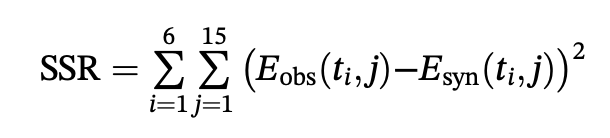  
* Hirose et al. (2022) --> 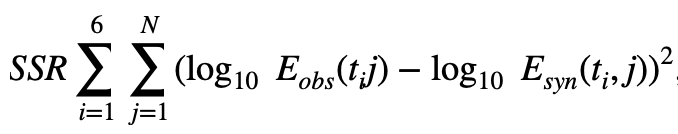

### Step 5 --- Determination of best-fit parameters 

In [15]:
def plot_fitting_curves(mean_free,intrinsic_b,tt,Eobs,Esyn,fname,dist):
    numb=len(intrinsic_b)
    plt.figure(figsize=(8,2))
    for nb in range(numb):
    
        plt.yscale('log', base=10)
        #plt.xlim(0,120) 
        plt.ylim( np.min(Eobs[nb][:-2]/2) , np.max(Eobs[nb][:-2]*2) )
        plt.plot( tt, Eobs[nb], "k-", linewidth=0.5)
        plt.plot( tt, Esyn[nb], "b-", linewidth=1)  

    plt.title("%s  %.2fkm   @%4.2f-%4.2f Hz, mean_free: %.2f  b: %.2f~%.2f"
            % ( fname,dist,fmin,fmax,mean_free,y[0],y[-1]))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amplitude")
    plt.tight_layout()   
    plt.show()            
                    

In [16]:
twindow=[20, 21, 22, 30, 31, 32] 
cvel=[2.6, 2.0, 1.8]                                     # phase velocity --> should be vary

x=np.zeros(120)    # mean_free_path search array
y=np.zeros(16)     # intrinsic_b search array

Esyn_temp=np.ndarray((len(x),len(y),npts//2+1))
Eobs_temp=np.ndarray((len(x),len(y),npts//2+1))

In [17]:
SSR_temppp=np.ndarray((len(x),len(y),len(twindow)))

SSR_final=np.ndarray((len(x),len(y)))
SSR_final[:][:]=0.

SSR=np.ndarray((nfreq,len(x),len(y)))
SSR[:][:][:]=0.

for fb in range(nfreq):
    fmin=freq[fb]
    fmax=freq[fb+1]
    c=cvel[fb]
    for aa in range(fnum):
    #for aa in range(0,1):
        r=float(vdist[aa])

        # grid search in combination of mean_free_path and intrinsic_b
        Esyn_temp[:][:][:]=0.
        Eobs_temp[:][:][:]=0.
        
        for nfree in range(len(x)):
            mean_free= 0.4 + 0.2 *nfree
            x[nfree]=mean_free
            for nb in range(len(y)):
                intrinsic_b=0.02*nb
                y[nb]=intrinsic_b        

                # calculate the Esyn and SSR for combination of mean_free_path and intrinsic_b
                for twn in range(npts//2+1):
                    tm=dt*twn
                    Eobs_temp[nfree][nb][twn]= fmsv_mean[aa][fb+1][twn]
                    
                    s0=c**2 * tm**2 -r**2
                    if s0 <= 0:
                        #print(twn,tm,s0,tm-r/c)
                        continue
                        
                    tmp=ESYN_RadiaTrans(mean_free, tm , r, c)
                    Esyn_temp[nfree][nb][twn]= tmp * math.exp(-1* intrinsic_b * tm)  
                # using scalar factor for further fitting processes --> shape matters more than amplitude
                                                  
                #### specific window --> find the scaling factor in the specific window
                for tsn in range(len(twindow)):
                    tsb=int(twindow[tsn]//dt)
                    SSR_temppp[nfree][nb][tsn]=0.
                    SSR_temppp[nfree][nb][tsn]=(math.log10(Eobs_temp[nfree][nb][tsb]) - math.log10(Esyn_temp[nfree][nb][tsb]))
                    
                #print("tsn",tsn,tsb,tse,"Eobs %.2f" % Eobs_temp[nfree][nb][tsn],"Esyn %.2e" % Esyn_temp[nfree][nb][tsn],
                #    "SSR_temp %.2f" % SSR_temppp[nfree][nb][tsn],"crap",crap,res_max)  
                crap=np.mean(SSR_temppp[nfree][nb])
                Esyn_temp[nfree][nb]*=(10**crap)  # scale the Esyn
            
            #### specific window 
            #### Calculate the SSR in the specific window            
                for tsn in range(len(twindow)):
                    tsb=int(twindow[tsn]//dt)
                    tse=int((twindow[tsn]+1)//dt)
                    SSR_temp=0.
                    for twn in range(tsb,tse):
                        SSR_temp+=(math.log10(Eobs_temp[nfree][nb][twn]) - math.log10(Esyn_temp[nfree][nb][twn]))**2
                SSR_final[nfree][nb]+=SSR_temp
            #print("mean_free: %.2f " % mean_free,", intri_b %.2f " %  intrinsic_b,
            #      "mean(Eobs): %.2e" % np.mean(Eobs_temp[nfree][nb]),"mean(Esyn): %.2e" % np.mean(Esyn_temp[nfree][nb]),
            #      "crap %.2f" % crap, "res_max %.2f" % res_max)
             
            #plot_fitting_curves(mean_free,y,fmsv_mean[aa][0][:],Eobs_temp[nfree],Esyn_temp[nfree],fname[aa],vdist[aa])
        #print("mean_free: %.2f " % mean_free,", intrinsic_b %.2f " %  intrinsic_b,"SSR: %.4f" % SSR_temp)
        SSR_final= SSR_final / (np.min(SSR_final[:][:]))
    SSR[fb]=SSR_final


## Plotting

In [18]:
def plot_grid_searching(freq,SSR):
    nfreq=len(freq)-1
    
    fig, ax = plt.subplots(1,nfreq, figsize=(16,4), sharex=False)
    
    for fb in range(nfreq): 
        fmin=freq[fb]
        fmax=freq[fb+1]

        loc=np.where(SSR[fb].T == np.amin(SSR[fb].T))
        locx=list(zip(loc[0], loc[1]))
        print("%4.2f-%4.2f Hz " % (fmin,fmax),"loc ",loc)
        ymin=y[loc[0]]
        xmin=x[loc[1]]
        print(" intrinsic_b %.2f " % ymin,"mean_free: %.2f " % xmin)

        grid = SSR[fb].T
        im=ax[fb].imshow(grid,extent=(x.min(), x.max(), y.max(), y.min()), aspect='auto',cmap = 'viridis_r',interpolation='spline16' )
        #im=ax[fb].imshow(grid,aspect='auto',cmap = 'viridis_r' )
        im.set_clim(1,10)    
        cb=plt.colorbar(im,extend='max')
        cb.set_label('SSR/SSR_min', rotation=90, labelpad=14)
        ax[fb].set_title("All pairs SSR  @%4.2f-%4.2f Hz" % (fmin,fmax) )
        ax[fb].set_xlabel("mean free path")
        ax[fb].set_ylabel("intrinsic_b")
        ax[fb].invert_yaxis()
        ax[fb].plot(xmin,ymin,"+", markersize=20, color='red')

    plt.tight_layout() 
    plt.show()     
    


0.50-1.00 Hz  loc  (array([3]), array([59]))
 intrinsic_b 0.06  mean_free: 12.20 
1.00-2.00 Hz  loc  (array([3]), array([60]))
 intrinsic_b 0.06  mean_free: 12.40 
2.00-4.00 Hz  loc  (array([3]), array([61]))
 intrinsic_b 0.06  mean_free: 12.60 


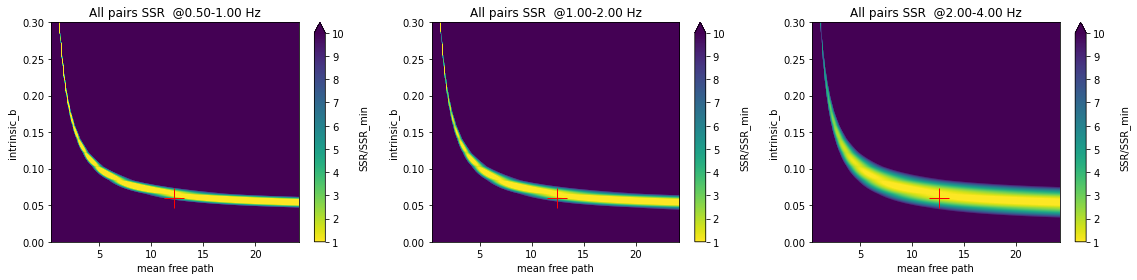

In [21]:
plot_grid_searching(freq,SSR)


In [20]:
#from noisepy.seis import plotting_modules 
#from noisepy.seis.asdfstore import ASDFStackStore,ASDFCCStore

#cc_store = ASDFCCStore(data_path, mode="r")
#stack_store = ASDFStackStore(data_path)
#plotting_modules.plot_all_moveout(stack_store, 'Allstack_linear', 0.5,1 ,'ZZ',0.05, 35, False)